# 21 - Meta Learners
 
 
Just to recap, we are now interested in finding treatment effect heterogeneity, that is, identifying how units respond differently to the treatment. In this framework, we want to estimate
 
$
\tau(x) = E[Y_i(1) − Y_i(0)|X] = E[\tau_i|X]
$
 
or, $E[\delta Y_i(t)|X]$ in the continuous case. In other words, we want to know how sensitive the units are to the treatment. This is super useful in the case where we can't treat everyone and need to do some prioritization of the treatment, for example when you want to give discounts but have a limited budget. 
 
Previously, we saw how we could transform the outcome variable $Y$ so that we can plug it in a predictive model and get a Conditional Average Treatment Effect (CATE) estimate. There, we had to pay a price in terms of variance increase. That's something we see a lot in Data Science. There isn't a single best method because each one has its downsides and upsides. For that reason, it is worth learning about many techniques so you can trade-off one for the other depending on the circumstances. In that spirit, this chapter will focus on giving more tools for you to have at your disposal. 
 
![img](data/img/meta-learners/learned-new-move.png)
 
Meta learners are a simple way to leverage off-the-shelf predictive machine learning methods in order to solve the same problem we've been looking at so far: estimating the CATE. Again, none of them is the single best one and each one has its weakness. 
I'll try to go over them, but keep in mind that this stuff is highly dependent on the context. Not only that, meta-learners deploy predictive ML models which can vary from linear regression and boosted decision trees to neural networks and gaussian processes. The success of the meta learner will be also highly dependent on what machine learning method it uses as its components. Oftentimes you just have to try out many different things and see what works best. 

In [2]:
from toolz import curry

@curry
def elast(data, y, t):
    return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
            np.sum((data[t] - data[t].mean())**2))

def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
#from nb21 import cumulative_gain, elast

Here, we will use the same data we had before, regathing investment advertisement emails. Again, the goal here is to figure out who will respond better to the email. There is a little twist, though. This time, we will use non-random data to train the models and random data to validate them. Dealing with-non random data is a much harder task, because the meta learners will need to debias the data **AND** estimate the CATE.

In [4]:
df = pd.read_stata('school_intervention_panel_final.dta', convert_categoricals=False)
follow_up_1_df = df[df['round'] == 0]
follow_up_2_df = df[df['round'] == 1]

/tmp/ipykernel_596/1814162779.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  df = pd.read_stata('school_intervention_panel_final.dta', convert_categoricals=False)


From Lasso/Ridge Model:
'dumm_rp_23_bl' : 'Student has computer with internet at home (Baseline)',
   'dumm_rp_59_bl' : 'Student says they are a saver (Baseline)',
    'dumm_rp_50_bl' : 'Student receives income (Baseline)',
        'dumm_rp_55_bl' : 'Student has borrowed money (any source) (Baseline)',
            'dumm_rp88__92AB_bl': 'Student has bought electronics shoes or clothing with cash/debit card (Baseline)',

In [5]:
categ = ['dumm_rp_23_bl', 'dumm_rp_59_bl', 'dumm_rp_50_bl', 'dumm_rp_55_bl', 'dumm_rp88__92AB_bl']
df_cleaned = follow_up_1_df.dropna(subset=categ)
df_cleaned = df_cleaned.dropna(subset=['treatment', 'dumm_rp88__92C_fup'])
print(df_cleaned.shape)

(13025, 212)


In [6]:
from sklearn.model_selection import train_test_split
#create a test and training dataset 
T = 'treatment'
y = 'dumm_rp88__92C_fup'
X = categ
train_df, test_df = train_test_split(df_cleaned, test_size=0.2, random_state=42)

## S-Learner (aka, the Go-Horse Learner)
 
The first learner we will use is the S-Learner. This is the simplest learner we can think of. We will use a single (hence the S) machine learning model $M_s$ to estimate
 
$
\mu(x) = E[Y| T, X]
$
 
To do so, we will simply include the treatment as a feature in the model that tries to predict the outcome Y. 

```note
Although I'll use a regressor to estimate $E[Y| T, X]$, since the outcome variable is binary, you could also use a classified. Just be sure to adapt the code so that the model outputs probabilities instead of the binary class, 0, 1.
```

In [7]:
! pip install lightgbm


In [8]:
from lightgbm import LGBMRegressor
np.random.seed(123)
s_learner = LGBMRegressor(max_depth=3, min_child_samples=30)
s_learner.fit(train_df[X + [T]], train_df[y])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12
[LightGBM] [Info] Number of data points in the train set: 10420, number of used features: 6
[LightGBM] [Info] Start training from score 0.240211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

LGBMRegressor(max_depth=3, min_child_samples=30)

Then, we can make predictions under different treatment regimes. The difference in predictions between the test and control will be our CATE estimate
 
$
\hat{\tau}(x)_i = M_s(X_i, T=1) - M_s(X_i, T=0)
$
 
If we put that in a diagram, here is what it would look like
 
![img](data/img/meta-learners/s-learner.png)
 
Now, let's see how we can implement this learner in code.

In [9]:
s_learner_cate_train = (s_learner.predict(train_df[X].assign(**{T: 1})) -
                        s_learner.predict(train_df[X].assign(**{T: 0})))

s_learner_cate_test = test_df.assign(
    cate=(s_learner.predict(test_df[X].assign(**{T: 1})) - # predict under treatment
          s_learner.predict(test_df[X].assign(**{T: 0}))) # predict under control
)

To evaluate this model, we will look at the cumulative gain curve in the test set. I'm also plotting the gain curve in the train. Since the train is biased, this curve cannot give any indication if the model is good, but it can point us out if we are overfitting to the training set. When this happens, the curve in the train set will be super high. If you want to see what that looks like, try replacing the `max_depth` parameter from 3 to 20.

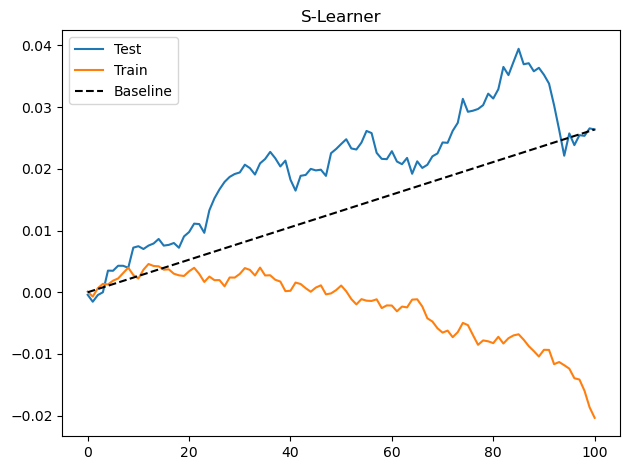

In [10]:
gain_curve_test = cumulative_gain(s_learner_cate_test, "cate", y="dumm_rp88__92C_fup", t="treatment")
gain_curve_train = cumulative_gain(train_df.assign(cate=s_learner_cate_train), "cate", y="dumm_rp88__92C_fup", t="treatment")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test_df, "dumm_rp88__92C_fup", "treatment")], linestyle="--", color="black", label="Baseline")
plt.legend()
plt.title("S-Learner");
plt.tight_layout()

plt.savefig("slearner2.png", dpi=300)
plt.show()




## T-Learner
 
follow up 1

In [25]:
categ = ['dumm_rp_23_bl', 'dumm_rp_59_bl', 'dumm_rp_50_bl', 'dumm_rp_55_bl', 'dumm_rp88__92AB_bl']

df_cleaned = follow_up_2_df.dropna(subset=categ)
df_cleaned = df_cleaned.dropna(subset=['treatment', 'dumm_rp88__92C_fup'])
print(df_cleaned.shape)

from sklearn.model_selection import train_test_split
#create a test and training dataset 
T = 'treatment'
y = 'dumm_rp88__92C_fup'
X = categ
train_df, test_df = train_test_split(df_cleaned, test_size=0.2, random_state=42)

(9716, 212)


In [26]:
np.random.seed(123)
train = train_df
test = test_df 

m0 = LGBMRegressor(max_depth=2, min_child_samples=60)
m1 = LGBMRegressor(max_depth=2, min_child_samples=60)

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

# estimate the CATE
t_learner_cate_train = m1.predict(train[X]) - m0.predict(train[X])
t_learner_cate_test = test.assign(cate=m1.predict(test[X]) - m0.predict(test[X]))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10
[LightGBM] [Info] Number of data points in the train set: 3886, number of used features: 5
[LightGBM] [Info] Start training from score 0.272002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

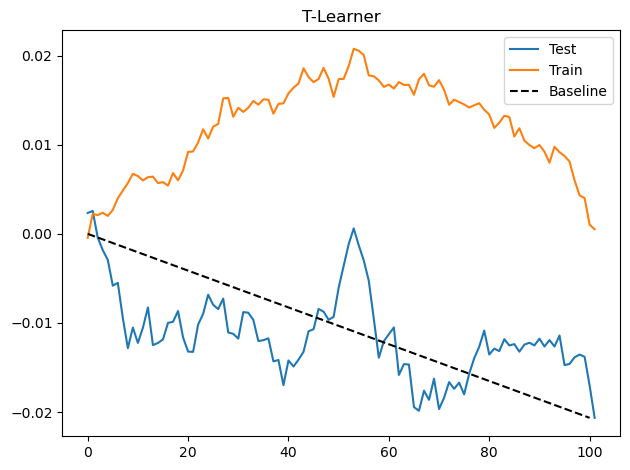

In [27]:
gain_curve_test = cumulative_gain(t_learner_cate_test, "cate", y="dumm_rp88__92C_fup", t="treatment")
gain_curve_train = cumulative_gain(train.assign(cate=t_learner_cate_train), "cate", y="dumm_rp88__92C_fup", t="treatment")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "dumm_rp88__92C_fup", "treatment")], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("T-Learner");

plt.tight_layout()

plt.savefig("tlearner2.png", dpi=300)
#plt.show()

In [28]:
average_cate_test = t_learner_cate_test['cate'].mean()
print(f"Average CATE (Test Data): {average_cate_test}")

Average CATE (Test Data): 0.0031036296738726713


In [29]:
results = {}  # Dictionary to store the results

for i in categ:
    grouped_cate = t_learner_cate_test.groupby(i)['cate'].mean()
    results[i] = grouped_cate  # Store the grouped results in the dictionary

# Output the results
for category, data in results.items():
    print(data)
    print("\n")

dumm_rp_23_bl
0.0   -0.000619
1.0    0.006441
Name: cate, dtype: float64


dumm_rp_59_bl
0.0   -0.010509
1.0    0.029708
Name: cate, dtype: float64


dumm_rp_50_bl
0.0    0.000650
1.0    0.004515
Name: cate, dtype: float64


dumm_rp_55_bl
0.0   -0.004415
1.0    0.022403
Name: cate, dtype: float64


dumm_rp88__92AB_bl
0.0   -0.020052
1.0    0.008456
Name: cate, dtype: float64




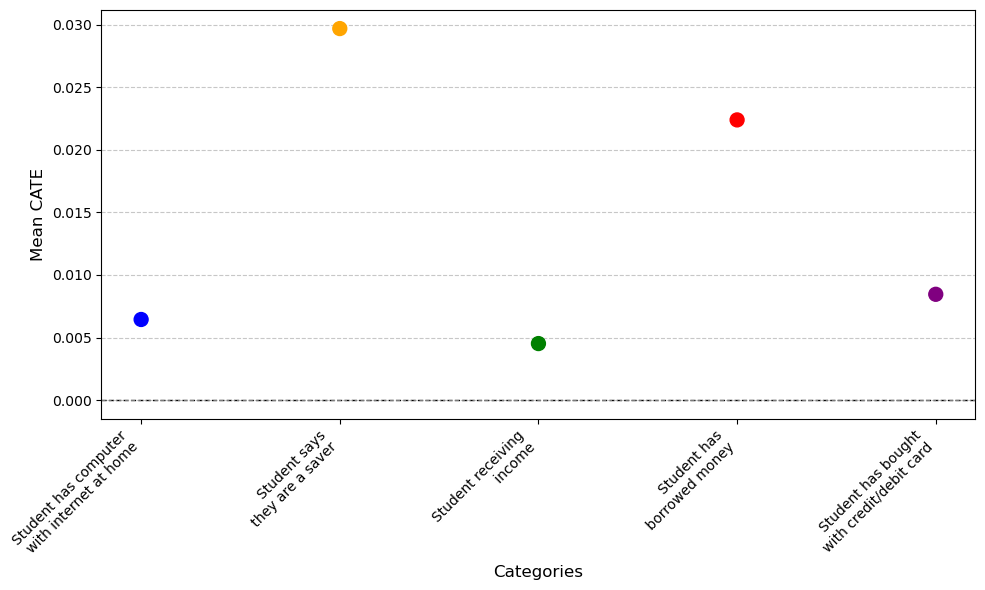

In [30]:
#follow up 2
import matplotlib.pyplot as plt

categories = [
    "Student has computer\n with internet at home",
    "Student says\n they are a saver",
    "Student receiving\n income",
    "Student has\n borrowed money",
    "Student has bought\n with credit/debit card"
]
mean_cate = [0.006441, 0.029708, 0.004515,  0.022403, 0.008456]
colors = ["blue", "orange", "green", "red", "purple"]


plt.figure(figsize=(10, 6))
x_positions = np.arange(len(categories))
plt.scatter(x_positions, mean_cate, c=colors, label="Mean CATE", s=100, zorder=3)


plt.axhline(0, color="black", linestyle="--", linewidth=1, label="Zero Effect", zorder=1)
plt.xticks(x_positions, categories, rotation=45, ha="right", fontsize=10)
plt.ylabel("Mean CATE", fontsize=12)
plt.xlabel("Categories", fontsize=12)
#plt.title("Conditional Average Treatment Effect (CATE)", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
#plt.legend(loc="upper left")
plt.tight_layout()

# Show the plot
plt.show()


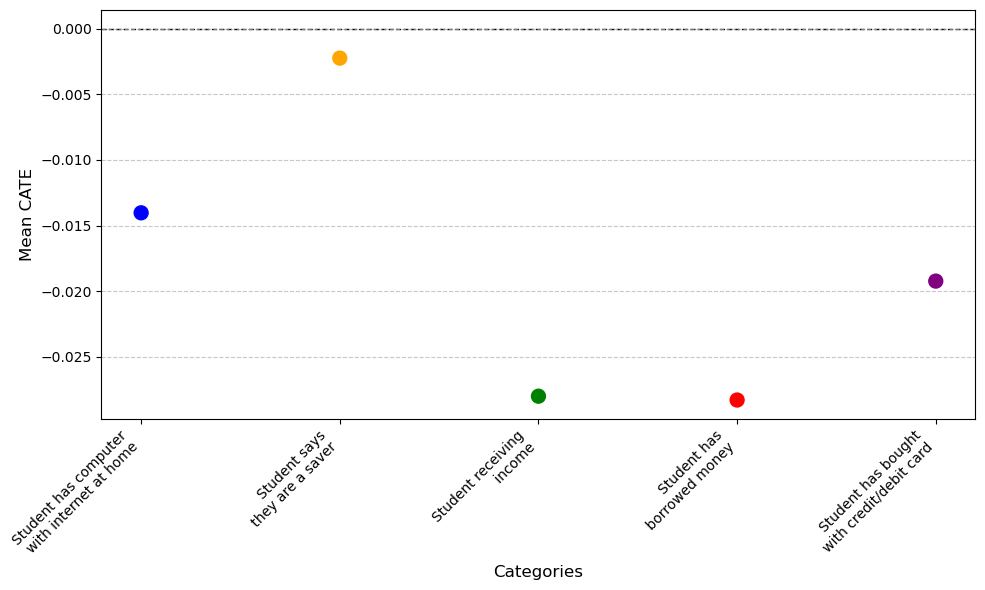

In [24]:
#follow up 1
import matplotlib.pyplot as plt

categories = [
    "Student has computer\n with internet at home",
    "Student says\n they are a saver",
    "Student receiving\n income",
    "Student has\n borrowed money",
    "Student has bought\n with credit/debit card"
]
mean_cate = [-0.014031, -0.002250, -0.027996, -0.028287, -0.019232]
colors = ["blue", "orange", "green", "red", "purple"]


plt.figure(figsize=(10, 6))
x_positions = np.arange(len(categories))
plt.scatter(x_positions, mean_cate, c=colors, label="Mean CATE", s=100, zorder=3)


plt.axhline(0, color="black", linestyle="--", linewidth=1, label="Zero Effect", zorder=1)
plt.xticks(x_positions, categories, rotation=45, ha="right", fontsize=10)
plt.ylabel("Mean CATE", fontsize=12)
plt.xlabel("Categories", fontsize=12)
#plt.title("Conditional Average Treatment Effect (CATE)", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
#plt.legend(loc="upper left")
plt.tight_layout()

# Show the plot
plt.show()


## X-Learner
 
The X-learner is significantly more complex to explain than the previous learner, but its implementation is quite simple, so don't worry. The X-Learner has two stages and a propensity score model. The first one is identical to the T-learner. First, we split the samples into treated and untreated and fit a ML model for the treated and for control.
 
$
\hat{M}_0(X) \approx E[Y| T=0, X]
$
 
$
\hat{M}_1(X) \approx E[Y| T=1, X]
$
 
Now, things start to take a turn. For the second stage, we impute the treatment effect for the control and for the treated using the models above
 
$
\hat{\tau}(X, T=0) = \hat{M}_1(X, T=0) - Y_{T=0}
$
 
$
\hat{\tau}(X, T=1) = Y_{T=1} - \hat{M}_0(X, T=1)
$
 
Then, we fit two more models to predict those effects
 
$
\hat{M}_{\tau 0}(X) \approx E[\hat{\tau}(X)|T=0]
$
 
$
\hat{M}_{\tau 1}(X) \approx E[\hat{\tau}(X)|T=1]
$

$$
\hat{Y}
$$
 
If we apply this on the image we've shown before, $\hat{\tau}(X, T=0)$, the imputed treatment effect on the untreated, would be the red crosses and the red dashed line would be $\hat{M}_{\tau 0}(X)$. Notice that this model is wrong. Because $\hat{\tau}(X, T=0)$ was made using the regularized, simple model, estimated on the treated, $\hat{M}_1$.  The treatment effect it imputes is non linear, since it **doesn't** capture the non-linearity in the Y variable.
 
In contrast, the blue dots are the imputed treatment effect for the treated, $\hat{\tau}(X, T=1)$. These effects are estimated using the correct model, $M_0$, trained in the untreated, large, sample. As a result, since its imputed treatment effects are correct, we are able to train a correct second stage model $\hat{M}_{\tau 1}(X)$, shown by the blue line. 
 
![img](data/img/meta-learners/second-stage-x.png)
 
So we have one model that is wrong because we've impute the treatment effects wrongly and another model that is correct because we've imputed those values correctly. Now, we need a way to combine the two in a way that gives more weight to the correct model. Here is where the propensity score model comes to play. Let $\hat{e}(x)$ be the propensity score model, we can combine the two second stage models as follows:
 
$
\hat{\tau(x)} = \hat{M}_{\tau 0}(X)\hat{e}(x) +  \hat{M}_{\tau 1}(X)(1-\hat{e}(x))
$
 
Since there are very few treated units, $\hat{e}(x)$ is very small. This will give a very small weight to the wrong model $\hat{M}_{\tau 0}(X)$. 

In contrast, $1-\hat{e}(x)$ is close to one, so we will give a high weight to the correct model $\hat{M}_{\tau 1}(X)$. More generally, weighted average using the propensity score will make sure we give more weight to the CATE model that was estimated where the assigned treatment was more likely. In other words, we will favor the model that was trained using more data. The following image shows the estimated CATE given by the X-learner and the T-learner.
 
![img](data/img/meta-learners/t-vs-x-learner.png)
 
As we can see, compared to the T-learner, the X-learner does a much better job in correcting the wrong CATE estimated at the non linearity. In general the X-learner performs better when a treatment group is much larger than the other. 
 
I know this might be a mouthful, but it will hopefully be clear once we move to the implementation. Just to summarize everything, here is the diagram of this learner.
 
![img](data/img/meta-learners/x-learner.png)
 
To the code at last! First, we have the first stage, which is exactly the same as the T-Learner. 

In [41]:
from sklearn.linear_model import LogisticRegression
train, test = train_test_split(df_cleaned, test_size=0.2, random_state=42)


np.random.seed(123)

# first stage models
m0 = LGBMRegressor(max_depth=2, min_child_samples=30)
m1 = LGBMRegressor(max_depth=2, min_child_samples=30)

# propensity score model
g = LogisticRegression(solver="lbfgs", penalty='none') 

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])
                       
g.fit(train[X], train[T]);

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10
[LightGBM] [Info] Number of data points in the train set: 3886, number of used features: 5
[LightGBM] [Info] Start training from score 0.272002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Now, we impute the treatment effect and fit the second stage models on them. 

In [42]:
d_train = np.where(train[T]==0,
                   m1.predict(train[X]) - train[y],
                   train[y] - m0.predict(train[X]))

# second stage
mx0 = LGBMRegressor(max_depth=2, min_child_samples=30)
mx1 = LGBMRegressor(max_depth=2, min_child_samples=30)

mx0.fit(train.query(f"{T}==0")[X], d_train[train[T]==0])
mx1.fit(train.query(f"{T}==1")[X], d_train[train[T]==1]);

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10
[LightGBM] [Info] Number of data points in the train set: 3886, number of used features: 5
[LightGBM] [Info] Start training from score 0.002927
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

Finally, we make corrected predictions using the propensity score model. 

In [43]:
def ps_predict(df, t): 
    return 
g.predict_proba(df[X])[:, t]
    
    
x_cate_train = (ps_predict(train,1)*mx0.predict(train[X]) +
                ps_predict(train,0)*mx1.predict(train[X]))

x_cate_test = test.assign(cate=(ps_predict(test,1)*mx0.predict(test[X]) +
                                ps_predict(test,0)*mx1.predict(test[X])))

In [44]:
average_cate_test = x_cate_test['cate'].mean()
print(f"Average CATE (Test Data): {average_cate_test}")

Average CATE (Test Data): 0.0031800299485894106


In [45]:
print("First few individual CATEs (Test Data):")
print(x_cate_test[['cate']].head())

First few individual CATEs (Test Data):
           cate
20068  0.049896
49378 -0.035276
6332   0.043593
11396  0.036770
69194  0.036770


In [46]:
results = {}  # Dictionary to store the results

for i in categ:
    grouped_cate = x_cate_test.groupby(i)['cate'].mean()
    results[i] = grouped_cate  # Store the grouped results in the dictionary

# Output the results
for category, data in results.items():
    print(data)
    print("\n")

dumm_rp_23_bl
0.0   -0.000148
1.0    0.006164
Name: cate, dtype: float64


dumm_rp_59_bl
0.0   -0.010768
1.0    0.030441
Name: cate, dtype: float64


dumm_rp_50_bl
0.0    0.000527
1.0    0.004707
Name: cate, dtype: float64


dumm_rp_55_bl
0.0   -0.00467
1.0    0.02333
Name: cate, dtype: float64


dumm_rp88__92AB_bl
0.0   -0.018498
1.0    0.008191
Name: cate, dtype: float64




In [47]:
import pandas as pd

# Assuming results is your dictionary storing grouped means
results = {}

for i in categ:
    grouped_cate = x_cate_test.groupby(i)['cate'].mean()
    results[i] = grouped_cate

# Convert results to a DataFrame
output_df = pd.concat(results, axis=1)

# Output the DataFrame as a table
print(output_df)

# Save the table as a CSV file
output_df.to_csv('grouped_results_table.csv')
print("The results have been saved to 'grouped_results_table.csv'.")

     dumm_rp_23_bl  dumm_rp_59_bl  dumm_rp_50_bl  dumm_rp_55_bl  \
0.0      -0.000148      -0.010768       0.000527       -0.00467   
1.0       0.006164       0.030441       0.004707        0.02333   

     dumm_rp88__92AB_bl  
0.0           -0.018498  
1.0            0.008191  
The results have been saved to 'grouped_results_table.csv'.


Lets see how our X-Learner does in the test. Again, let's plot the cumulative gain curve. 

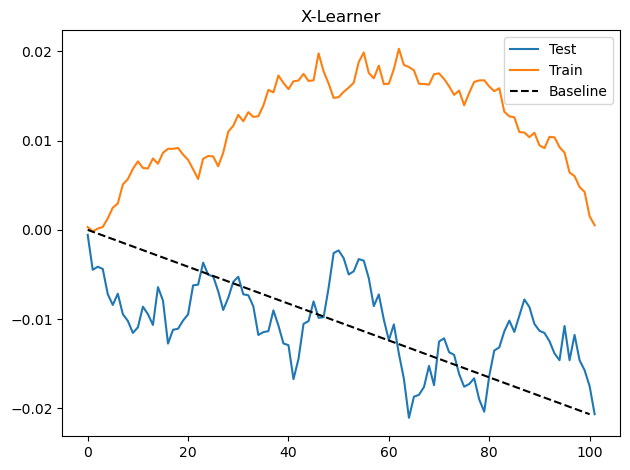

In [48]:
gain_curve_test = cumulative_gain(x_cate_test, "cate", y="dumm_rp88__92C_fup", t="treatment")
gain_curve_train = cumulative_gain(train.assign(cate=x_cate_train), "cate", y="dumm_rp88__92C_fup", t="treatment")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "dumm_rp88__92C_fup", "treatment")], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("X-Learner");

plt.tight_layout()

plt.savefig("slearner2.png", dpi=300)
plt.show()